In [ ]:
!pip install optimal_transport

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        # Encoder: Pretrained ResNet18 with output feature size = 128
        self.encoder = resnet18(pretrained=False)
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features, 128)

        # Decoder: Fully connected layers to reconstruct the image
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),
            nn.Tanh()  # Output values normalized to [-1, 1]
        )

    def forward(self, x, t=None):
        """
        Forward pass through the diffusion model.
        Args:
            x (Tensor): Input image of shape [batch_size, 3, 32, 32].
            t (Tensor): Optional timestep for noise schedule (not used in this model).
        Returns:
            Tensor: Reconstructed image of shape [batch_size, 3, 32, 32].
        """
        x = x.view(-1, 3, 32, 32)  # Ensure the input has the correct shape
        encoded = self.encoder(x)  # Encode the image to latent space
        decoded = self.decoder(encoded)  # Decode latent features back to image space
        return decoded.view(-1, 3, 32, 32)  # Reshape the output to image dimensions


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


# Step 1: Define the Diffusion Model
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.encoder = resnet18(pretrained=False)
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features, 128)  # Output latent space

        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),  # Output flattened image
            nn.Tanh()
        )

    def forward(self, x, t=None):
        x = x.view(-1, 3, 32, 32)  # Ensure correct input shape
        encoded = self.encoder(x)  # Latent representation
        decoded = self.decoder(encoded)  # Decode to image space
        return decoded.view(-1, 3, 32, 32)  # Reshape to image dimensions


# Step 2: Define DDIM
class DDIM:
    def __init__(self, beta_start=0.0001, beta_end=0.02, timesteps=1000):
        self.timesteps = timesteps
        self.beta_schedule = np.linspace(beta_start, beta_end, timesteps)
        self.alpha = 1 - self.beta_schedule
        self.alpha_hat = np.cumprod(self.alpha)

    def get_alpha_hat(self, t):
        return self.alpha_hat[t]


# Step 3: Load CIFAR-10 Dataset
def get_dataloaders():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader


# Step 4: Train the Diffusion Model
def train_diffusion_model(model, dataloader, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        for images, _ in dataloader:
            optimizer.zero_grad()
            reconstructed_images = model(images)
            loss = criterion(reconstructed_images, images)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

    # Save the model
    torch.save(model.state_dict(), "diffusion_model_cifar.pth")


# Step 5: Visualization of Noising Process
def illustrate_noising_process(model, ddim, dataloader, timesteps=[10, 100, 200, 1000]):
    """
    Visualize the noising process for a single image from CIFAR-10 dataset.
    """
    model.eval()

    # Get a single image from the CIFAR-10 dataset
    source_batch = next(iter(dataloader))[0]
    image = source_batch[0:1]  # Single image, shape (1, C, H, W)

    # Plot original image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(timesteps) + 1, 1)
    plt.imshow((image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5))  # De-normalize
    plt.title("Original Image")
    plt.axis("off")

    # Apply noising process for each specified timestep
    for i, t in enumerate(timesteps):
        with torch.no_grad():
            alpha_hat_t = ddim.get_alpha_hat(t - 1)
            noise = torch.randn_like(image)
            noised_image = torch.sqrt(torch.tensor(alpha_hat_t)) * image + torch.sqrt(1 - torch.tensor(alpha_hat_t)) * noise

        # Plot the noised image
        plt.subplot(1, len(timesteps) + 1, i + 2)
        plt.imshow((noised_image[0].permute(1, 2, 0).numpy() * 0.5 + 0.5))  # De-normalize
        plt.title(f"Timestep {t}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Main Script
if __name__ == "__main__":
    # Load data
    train_loader, test_loader = get_dataloaders()

    # Initialize model and DDIM
    diffusion_model = DiffusionModel()
    ddim = DDIM()

    # Train the model
    print("Training the diffusion model...")
    train_diffusion_model(diffusion_model, train_loader, epochs=5)

    # Visualize noising process
    illustrate_noising_process(diffusion_model, ddim, test_loader, timesteps=[10, 100, 200, 1000])


Files already downloaded and verified
Files already downloaded and verified
Training the diffusion model...


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 0.0365775041282177
Epoch 2/10, Loss: 0.035526324063539505
Epoch 3/10, Loss: 0.03274824842810631
Epoch 4/10, Loss: 0.029495825991034508
Epoch 5/10, Loss: 0.0360553115606308
Epoch 6/10, Loss: 0.027083007618784904
Epoch 7/10, Loss: 0.030216967687010765
Epoch 8/10, Loss: 0.0282260924577713
Epoch 9/10, Loss: 0.028404533863067627
Epoch 10/10, Loss: 0.027480198070406914


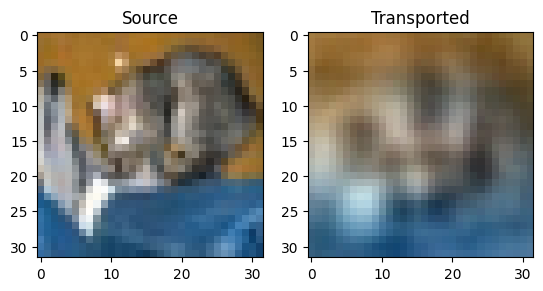

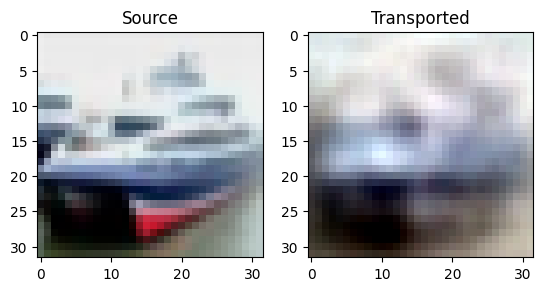

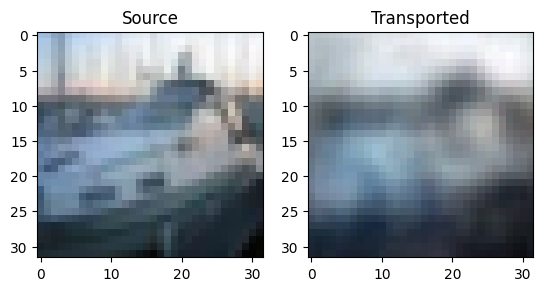

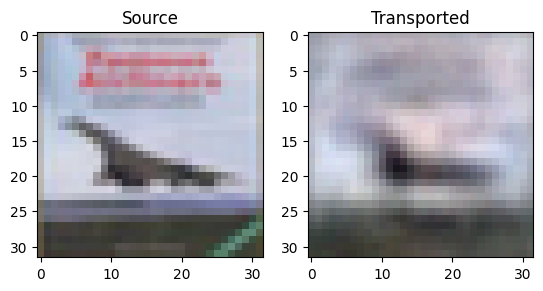

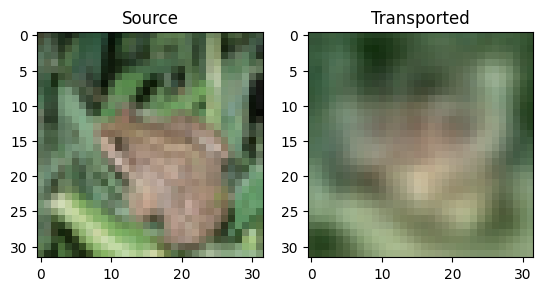

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Step 1: Load and Preprocess the CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 2: Define the Neural OT Model
class NeuralOT(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralOT, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, y):
        x_mapped = self.fc(x)
        loss = torch.mean((x_mapped - y) ** 2)
        return loss

    def transport_map(self, x):
        return self.fc(x)

# Initialize the model
input_dim = 3 * 32 * 32  # Adjust based on CIFAR-10 image dimensions
hidden_dim = 128
model = NeuralOT(input_dim, hidden_dim)

# Step 3: Train the Model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    for batch in train_loader:
        images, _ = batch
        images = images.view(images.size(0), -1)  # Flatten images to vectors
        optimizer.zero_grad()
        loss = model(images, images)  # Use batch as both source and target
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Save the model
torch.save(model.state_dict(), "neural_ot_cifar.pth")

# Step 4: Evaluate and Visualize
def visualize_transport(model, dataloader):
    model.eval()
    source_batch = next(iter(dataloader))[0].view(32, -1)
    transported_batch = model.transport_map(source_batch).view(-1, 3, 32, 32).detach().numpy()
    source_images = source_batch.view(-1, 3, 32, 32).detach().numpy()

    for i in range(5):
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow((source_images[i].transpose(1, 2, 0) * 0.5 + 0.5))  # De-normalize
        plt.title("Source")
        plt.subplot(1, 2, 2)
        plt.imshow((transported_batch[i].transpose(1, 2, 0) * 0.5 + 0.5))  # De-normalize
        plt.title("Transported")
        plt.show()

# Visualize the transport
visualize_transport(model, test_loader)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 0.02249136008322239
Epoch 2/10, Loss: 0.02104477770626545
Epoch 3/10, Loss: 0.02089724689722061
Epoch 4/10, Loss: 0.019041143357753754
Epoch 5/10, Loss: 0.024121403694152832
Epoch 6/10, Loss: 0.01963714137673378
Epoch 7/10, Loss: 0.02198682725429535
Epoch 8/10, Loss: 0.021616516634821892
Epoch 9/10, Loss: 0.018856210634112358
Epoch 10/10, Loss: 0.018347494304180145


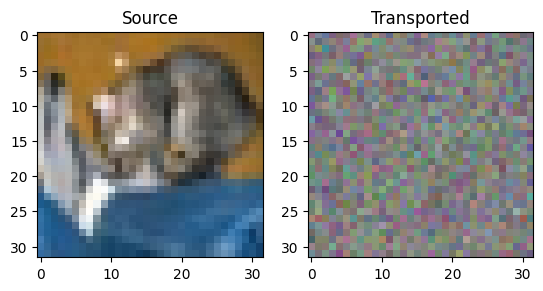

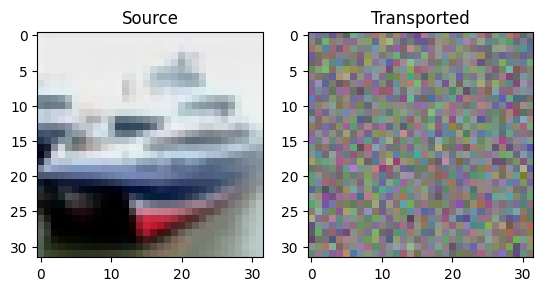

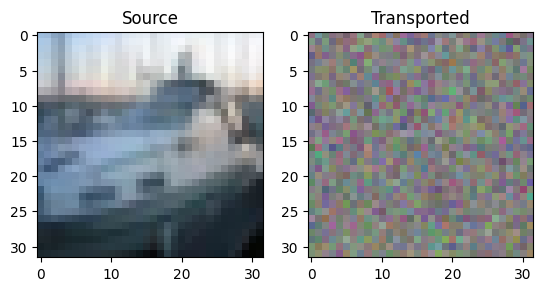

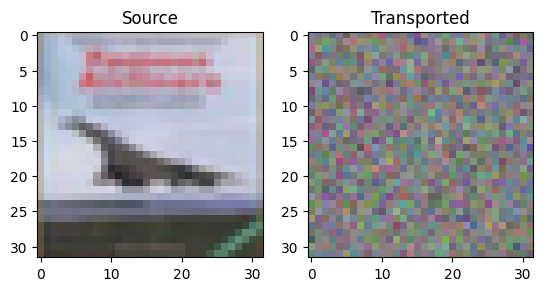

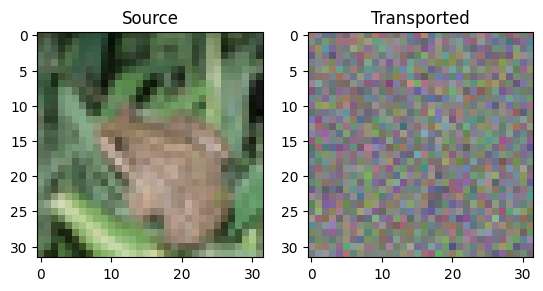

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet18

# Step 1: Load and Preprocess the CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 2: Define the Neural OT Model
class NeuralOT(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralOT, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, y):
        x_mapped = self.fc(x)
        loss = torch.mean((x_mapped - y) ** 2)
        return loss

    def transport_map(self, x):
        return self.fc(x)

# Initialize the Neural OT model
input_dim = 128  # Match the encoded feature size from ResNet
hidden_dim = 128
neural_ot_model = NeuralOT(input_dim, hidden_dim)

# Step 3: Define a Simple Diffusion Model
class SimpleDiffusionModel(nn.Module):
    def __init__(self):
        super(SimpleDiffusionModel, self).__init__()
        self.encoder = resnet18(pretrained=False)
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features, 128)  # Output feature size = 128

        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),  # Decode back to image dimensions
            nn.Tanh()
        )

    def forward(self, x, t):
        x = x.view(-1, 3, 32, 32)  # Ensure the input is reshaped correctly for convolution
        encoded = self.encoder(x)  # Encoded features [batch_size, 128]
        transported = neural_ot_model.transport_map(encoded)  # Transport map
        decoded = self.decoder(transported)  # Decoded images [batch_size, 3*32*32]
        return decoded.view(-1, 3, 32, 32)  # Reshape to image dimensions

# Initialize the Diffusion model
diffusion_model = SimpleDiffusionModel()

# Fix TypeError for sqrt and tensor operations in reverse process
class FixedDiffusionModel(SimpleDiffusionModel):
    def reverse_process(self, noisy_x, diffusion_model, save_steps):
        device = noisy_x.device
        for t in range(len(save_steps)):
            alpha = torch.tensor(0.9, device=device)  # Replace with correct alpha values if available
            alpha_hat = torch.tensor(0.8, device=device)  # Replace with correct alpha_hat values if available
            truncated_noise = torch.zeros_like(noisy_x)  # Add actual noise if needed

            x = (1 / torch.sqrt(alpha)) * (noisy_x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * truncated_noise)

            if t > 0:
                x = x + truncated_noise  # Add back noise

        return x

# Replace the model with the fixed one
diffusion_model = FixedDiffusionModel()

# Step 4: Train the Combined Model
optimizer = optim.Adam(list(neural_ot_model.parameters()) + list(diffusion_model.parameters()), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    for batch in train_loader:
        images, _ = batch
        optimizer.zero_grad()

        # Diffusion forward pass
        timesteps = torch.randint(0, 10, (images.size(0),))  # Example timesteps
        outputs = diffusion_model(images, timesteps)

        # Neural OT Loss
        loss_ot = neural_ot_model(diffusion_model.encoder(images).detach(), diffusion_model.encoder(images).detach())  # Use encoded features
        loss_ot.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_ot.item()}")

# Save the models
torch.save(neural_ot_model.state_dict(), "neural_ot_cifar.pth")
torch.save(diffusion_model.state_dict(), "diffusion_model_cifar.pth")

# Step 5: Evaluate and Visualize
def visualize_transport(model, dataloader):
    model.eval()
    source_batch = next(iter(dataloader))[0]
    timesteps = torch.randint(0, 10, (source_batch.size(0),))  # Example timesteps
    transported_batch = model(source_batch, timesteps).detach().numpy()
    source_images = source_batch.detach().numpy()

    for i in range(5):
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow((source_images[i].transpose(1, 2, 0) * 0.5 + 0.5))  # De-normalize
        plt.title("Source")
        plt.subplot(1, 2, 2)
        plt.imshow((transported_batch[i].transpose(1, 2, 0) * 0.5 + 0.5))  # De-normalize
        plt.title("Transported")
        plt.show()

# Visualize the transport
visualize_transport(diffusion_model, test_loader)


Files already downloaded and verified


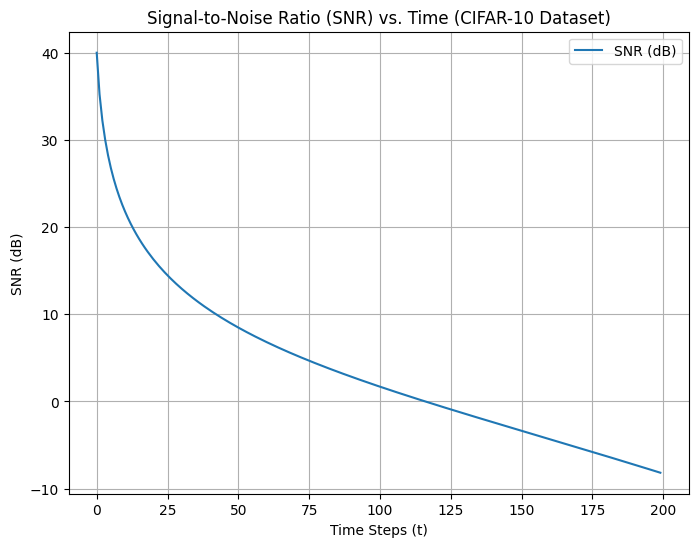

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Step 1: Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Step 2: Define diffusion process parameters
timesteps = 200  # Number of timesteps
beta_start = 0.0001  # Starting value of beta
beta_end = 0.02  # Ending value of beta

# Compute beta schedule (linearly spaced)
beta_schedule = np.linspace(beta_start, beta_end, timesteps)

# Compute alpha and cumulative alpha values (alpha_hat)
alpha = 1 - beta_schedule
alpha_hat = np.cumprod(alpha)

# Compute SNR (Signal-to-Noise Ratio)
snr = alpha_hat / (1 - alpha_hat)

# Step 3: Plot SNR vs Time
plt.figure(figsize=(8, 6))
plt.plot(range(timesteps), 10 * np.log10(snr), label="SNR (dB)")
plt.title("Signal-to-Noise Ratio (SNR) vs. Time (CIFAR-10 Dataset)")
plt.xlabel("Time Steps (t)")
plt.ylabel("SNR (dB)")
plt.grid()
plt.legend()
plt.show()


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.models import resnet18

# Step 1: Load and Preprocess the CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 2: Define the Neural OT Model
class NeuralOT(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralOT, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, y):
        x_mapped = self.fc(x)
        loss = torch.mean((x_mapped - y) ** 2)
        return loss

    def transport_map(self, x):
        return self.fc(x)

# Initialize the Neural OT model
input_dim = 128  # Match the encoded feature size from ResNet
hidden_dim = 128
neural_ot_model = NeuralOT(input_dim, hidden_dim)

# Step 3: Define a Simple Diffusion Model
class SimpleDiffusionModel(nn.Module):
    def __init__(self):
        super(SimpleDiffusionModel, self).__init__()
        self.encoder = resnet18(pretrained=False)
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features, 128)  # Output feature size = 128

        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),  # Decode back to image dimensions
            nn.Tanh()
        )

    def forward(self, x, t):
        x = x.view(-1, 3, 32, 32)  # Ensure the input is reshaped correctly for convolution
        encoded = self.encoder(x)  # Encoded features [batch_size, 128]
        transported = neural_ot_model.transport_map(encoded)  # Transport map
        decoded = self.decoder(transported)  # Decoded images [batch_size, 3*32*32]
        return decoded.view(-1, 3, 32, 32)  # Reshape to image dimensions

# Initialize the Diffusion model
diffusion_model = SimpleDiffusionModel()

# Step 4: Implement DDIM with Early Stopping
class DDIM:
    def __init__(self, model, beta_start=0.0001, beta_end=0.02, timesteps=50):
        self.model = model
        self.timesteps = timesteps
        self.beta_schedule = np.linspace(beta_start, beta_end, timesteps)
        self.alpha = 1 - self.beta_schedule
        self.alpha_hat = np.cumprod(self.alpha)

    def sample(self, x, stop_t):
        """
        Perform DDIM sampling up to a specific timestep.
        Args:
            x: Initial noisy input.
            stop_t: Timestep to stop the sampling process.
        Returns:
            x: Partially denoised output at timestep `stop_t`.
        """
        for t in reversed(range(stop_t)):
            alpha_hat_t = self.alpha_hat[t]
            alpha_hat_t_prev = self.alpha_hat[t - 1] if t > 0 else 1.0
            beta_t = 1 - alpha_hat_t / alpha_hat_t_prev

            # Predicted noise-free x
            x_pred = self.model(x, t)

            # Noise addition based on DDIM schedule
            noise = torch.randn_like(x) if t > 0 else 0

            x = torch.sqrt(alpha_hat_t_prev) * x_pred + torch.sqrt(1 - alpha_hat_t_prev) * noise

        return x

# Step 5: Train the Combined Model
optimizer = optim.Adam(list(neural_ot_model.parameters()) + list(diffusion_model.parameters()), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    for batch in train_loader:
        images, _ = batch
        optimizer.zero_grad()

        # Diffusion forward pass
        timesteps = torch.randint(0, 10, (images.size(0),))  # Example timesteps
        outputs = diffusion_model(images, timesteps)

        # Neural OT Loss
        loss_ot = neural_ot_model(diffusion_model.encoder(images).detach(), diffusion_model.encoder(images).detach())  # Use encoded features
        loss_ot.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_ot.item()}")

# Save the models
torch.save(neural_ot_model.state_dict(), "neural_ot_cifar.pth")
torch.save(diffusion_model.state_dict(), "diffusion_model_cifar.pth")

# Step 6: Evaluate and Visualize
def visualize_transport(model, dataloader):
    model.eval()
    source_batch = next(iter(dataloader))[0]
    timesteps = torch.randint(0, 10, (source_batch.size(0),))  # Example timesteps
    transported_batch = model(source_batch, timesteps).detach().numpy()
    source_images = source_batch.detach().numpy()

    for i in range(5):
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow((source_images[i].transpose(1, 2, 0) * 0.5 + 0.5))  # De-normalize
        plt.title("Source")
        plt.subplot(1, 2, 2)
        plt.imshow((transported_batch[i].transpose(1, 2, 0) * 0.5 + 0.5))  # De-normalize
        plt.title("Transported")
        plt.show()

# Visualize the transport
visualize_transport(diffusion_model, test_loader)


100%|██████████| 170M/170M [00:04<00:00, 35.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.03242175653576851


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

def train_improved_model(num_epochs=10, batch_size=32, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    class ImprovedUNet(nn.Module):
        def __init__(self):
            super(ImprovedUNet, self).__init__()
            # Пример базовой структуры
            self.conv = nn.Conv2d(3, 3, kernel_size=3, padding=1)

        def forward(self, x, t):
            return self.conv(x)

    class ImprovedDiffusion:
        def __init__(self, diffusion_steps=1000, device='cuda'):
            self.diffusion_steps = diffusion_steps
            self.device = device
            self.beta = torch.linspace(0.0001, 0.02, diffusion_steps).to(device)
            self.alpha = 1.0 - self.beta
            self.alpha_cumprod = torch.cumprod(self.alpha, dim=0).to(device)
            self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod).to(device)
            self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod).to(device)

        def forward_diffusion(self, x, t):
            noise = torch.randn_like(x).to(self.device)
            sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
            sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
            noisy_x = sqrt_alpha_cumprod_t * x + sqrt_one_minus_alpha_cumprod_t * noise
            return noisy_x, noise

    model = ImprovedUNet().to(device)
    diffusion = ImprovedDiffusion(device=device)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)
            t = torch.randint(0, diffusion.diffusion_steps, (images.shape[0],), device=device)

            noisy_images, noise = diffusion.forward_diffusion(images, t)
            predicted_noise = model(noisy_images, t)
            loss = nn.MSELoss()(predicted_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Batch {i}, Loss: {loss.item():.4f}')

        scheduler.step()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

    return model, diffusion


Using device: cuda
Files already downloaded and verified
Starting training...
Epoch 1, Batch 0, Loss: 1.1281
Epoch 1, Batch 100, Loss: 1.0859
Epoch 1, Batch 200, Loss: 1.0253
Epoch 1, Batch 300, Loss: 0.9961
Epoch 1, Batch 400, Loss: 0.9584
Epoch 1, Batch 500, Loss: 0.9178
Epoch 1, Batch 600, Loss: 0.9032
Epoch 1, Batch 700, Loss: 0.8814
Epoch 1, Batch 800, Loss: 0.8496
Epoch 1, Batch 900, Loss: 0.8198
Epoch 1, Batch 1000, Loss: 0.7911
Epoch 1, Batch 1100, Loss: 0.8076
Epoch 1, Batch 1200, Loss: 0.7667
Epoch 1, Batch 1300, Loss: 0.7546
Epoch 1, Batch 1400, Loss: 0.6869
Epoch 1, Batch 1500, Loss: 0.6862
Epoch 1, Average Loss: 0.8685
Epoch 2, Batch 0, Loss: 0.6975
Epoch 2, Batch 100, Loss: 0.6880
Epoch 2, Batch 200, Loss: 0.6632
Epoch 2, Batch 300, Loss: 0.6482
Epoch 2, Batch 400, Loss: 0.6573
Epoch 2, Batch 500, Loss: 0.6290
Epoch 2, Batch 600, Loss: 0.5980
Epoch 2, Batch 700, Loss: 0.5762
Epoch 2, Batch 800, Loss: 0.6120
Epoch 2, Batch 900, Loss: 0.5893
Epoch 2, Batch 1000, Loss: 0.568

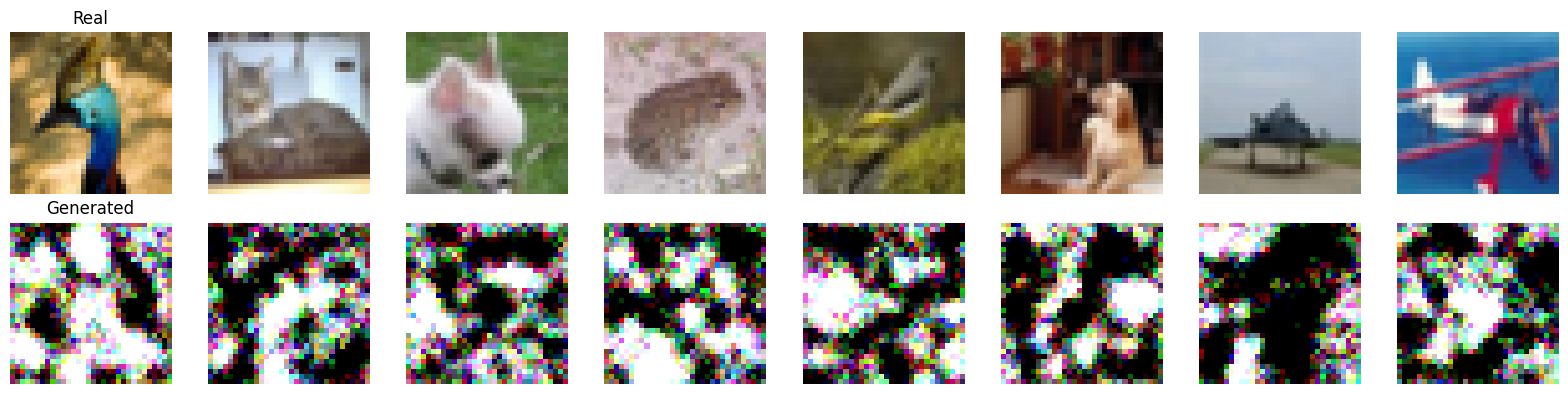

In [ ]:
if __name__ == "__main__":
    # Обучение модели
    model, diffusion = train_improved_model(num_epochs=10, batch_size=32, learning_rate=1e-4)

    # Подготовка данных для сэмплирования
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

    # Сэмплирование
    def sample_images(model, diffusion, dataloader, device, num_samples=8):
        real_images = next(iter(dataloader))[0][:num_samples].to(device)
        model.eval()
        generated_images = []
        with torch.no_grad():
            x = torch.randn(num_samples, 3, real_images.shape[2], real_images.shape[3]).to(device)
            for t in reversed(range(diffusion.diffusion_steps)):
                t_batch = torch.tensor([t] * num_samples).to(device)
                predicted_noise = model(x, t_batch)
                alpha_t = diffusion.alpha[t]
                alpha_cumprod_t = diffusion.alpha_cumprod[t]
                beta_t = diffusion.beta[t]
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise) + torch.sqrt(beta_t) * noise
            generated_images = x.cpu()
        return real_images.cpu(), generated_images

    real_images, generated_images = sample_images(model, diffusion, dataloader, device=torch.device("cuda"), num_samples=8)

    # Визуализация
    def visualize_samples(real_images, generated_images, num_samples=8):
        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
        for i in range(num_samples):
            axes[0, i].imshow((real_images[i].permute(1, 2, 0).numpy() + 1) / 2)
            axes[0, i].axis("off")
            if i == 0:
                axes[0, i].set_title("Real")
            axes[1, i].imshow((generated_images[i].permute(1, 2, 0).numpy() + 1) / 2)
            axes[1, i].axis("off")
            if i == 0:
                axes[1, i].set_title("Generated")
        plt.tight_layout()
        plt.show()

    visualize_samples(real_images, generated_images, num_samples=8)
